                          MNLogit Regression Results                          
Dep. Variable:                 choice   No. Observations:                 3000
Model:                        MNLogit   Df Residuals:                     2995
Method:                           MLE   Df Model:                            4
Date:                Wed, 28 May 2025   Pseudo R-squ.:                  0.1123
Time:                        23:38:55   Log-Likelihood:                -1695.0
converged:                       True   LL-Null:                       -1909.5
Covariance Type:            nonrobust   LLR p-value:                 1.454e-91
  choice=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7753      0.136     13.048      0.000       1.509       2.042
ad_bin        -0.7489      0.085     -8.834      0.000      -0.915      -0.583
price         -0.0901      0.006    -16.209      0.0

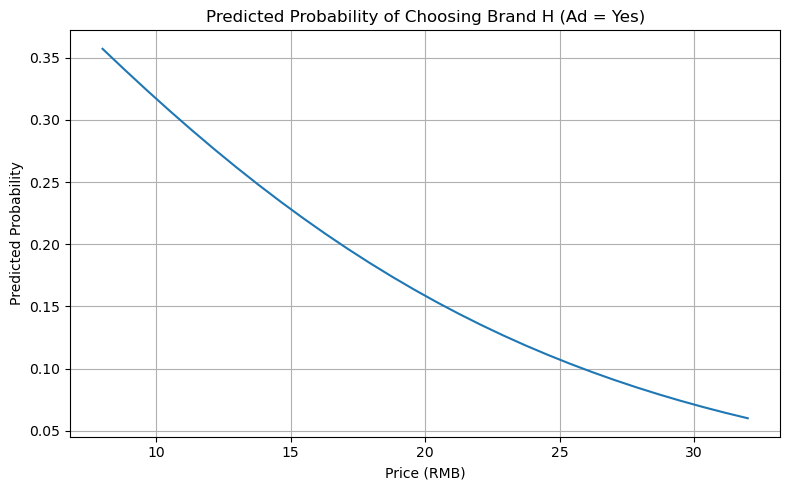

In [1]:
# HW3: Multinomial Logit Estimation, WTP, and Predicted Probabilities

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---
df = pd.read_csv("conjoint_data.csv")

# Encode categorical variables
df['ad_bin'] = df['ad'].map({'Yes': 1, 'No': 0})
df['brand_H'] = (df['brand'] == 'H').astype(int)
df['brand_P'] = (df['brand'] == 'P').astype(int)

# --- 2. Fit Multinomial Logit Model ---
X = df[['ad_bin', 'price', 'brand_H', 'brand_P']]
X = sm.add_constant(X).astype(float)
y = df['choice'].astype(int)

model = sm.MNLogit(y, X)
result = model.fit(disp=0)
print(result.summary())

# Save coefficient table
coef_summary = result.summary2().tables[1]
coef_summary.to_csv("mnl_coefficients.csv")

# --- 3. Willingness to Pay (WTP) ---
params = result.params
wtp = {
    "Ad Effect": -params.loc['ad_bin', 0] / params.loc['price', 0],
    "Brand H": -params.loc['brand_H', 0] / params.loc['price', 0],
    "Brand P": -params.loc['brand_P', 0] / params.loc['price', 0]
}
wtp_df = pd.DataFrame.from_dict(wtp, orient='index', columns=['WTP (RMB)']).round(2)
print("\nWillingness to Pay (RMB):\n", wtp_df)
wtp_df.to_csv("wtp_summary.csv")

# --- 4. Predicted Probabilities by Price ---
price_range = np.linspace(df['price'].min(), df['price'].max(), 30)
df_plot = pd.DataFrame({
    'const': 1.0,
    'ad_bin': 1,      # Simulate Ad = Yes
    'price': price_range,
    'brand_H': 1,     # Simulate Brand H
    'brand_P': 0
})

pred_probs = result.predict(df_plot)
pred_class1 = pred_probs.iloc[:, 1]

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=price_range, y=pred_class1)
plt.title("Predicted Probability of Choosing Brand H (Ad = Yes)")
plt.xlabel("Price (RMB)")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.tight_layout()
plt.savefig("probability_vs_price.png")
plt.show()


In [4]:
pip install bambi


Note: you may need to restart the kernel to use updated packages.


In [7]:
import arviz as az

az.summary(results, round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[not_chosen],-0.88,0.13,-1.11,-0.60,0.0,0.0,4143.16,2749.87,1.0
price[not_chosen],0.09,0.01,0.08,0.10,0.0,0.0,3936.19,2712.81,1.0
ad_bin[not_chosen],0.75,0.08,0.60,0.92,0.0,0.0,4432.52,2819.11,1.0
"brand[not_chosen, N]",-0.89,0.11,-1.10,-0.69,0.0,0.0,4270.74,2934.70,1.0
"brand[not_chosen, P]",-0.49,0.11,-0.69,-0.29,0.0,0.0,4177.12,3134.64,1.0


In [8]:
summary_df = az.summary(results, round_to=2)
summary_df.to_csv("bambi_summary.csv")


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

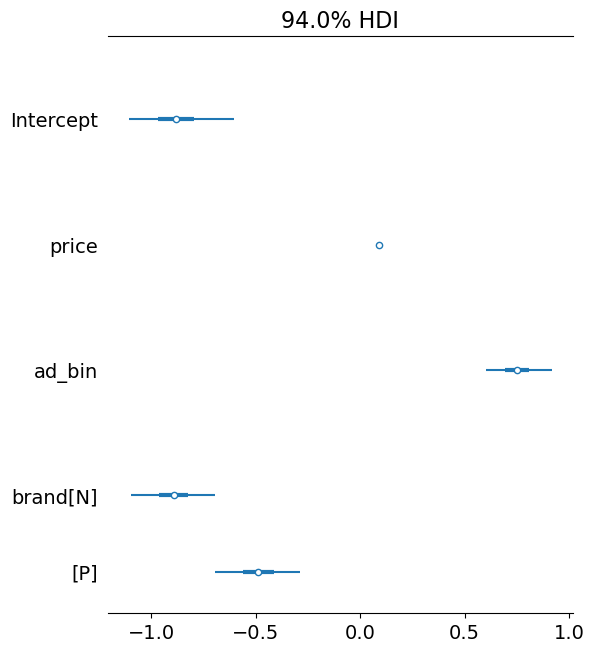

In [9]:
az.plot_forest(results, combined=True)
